# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

***

# 1. Pricing the Callable Bond

### Data

Use the data from the following files.
* `../data/callable_bonds_2025-02-13.xlsx`
* `../data/discount_curve_2025-02-13.xlsx`

The data contains info on the following bonds.

`Callable`
* `FHLMC 4.41 01/28/30` is a callable bond, and it is the primary object of our analysis.

`Reference` bonds for a forward price.
* `FHLMC 0.97 01/28/28`
* `FHLMC 1.25 01/29/30`

Though these are technically callable, they are far out of the money. Thus, for the purposes of this analysis, we consider the reference bonds as non-callable bonds.

These reference bonds are analyzed in optional problems at the end, but mostly you will focus on the `callable` bond.

In [207]:
FILE_BOND = '../data/callable_bonds_2025-02-13.xlsx'
FILE_CURVE = '../data/discount_curve_2025-02-13.xlsx'

KEY_CALLABLE = 'FHLMC 4.41 01/28/30'
KEY_REF_T1 = 'FHLMC 0.97 01/28/28'
KEY_REF_T2 = 'FHLMC 1 1/4 01/29/30'

### Bond Info

In [208]:
import pandas as pd

info = pd.read_excel(FILE_BOND,sheet_name='info').set_index('info')
info.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call"], :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


### Quoted Values

In [209]:
quotes = pd.read_excel(FILE_BOND,sheet_name='quotes').set_index('quotes')
quotes.style.format('{:.2f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13,2025-02-13,2025-02-13
TTM,2.95,4.96,4.96
Clean Price,90.14,85.11,99.89
Dirty Price,90.19,85.16,100.09
Accrued Interest,0.04,0.05,0.20
YTM Call,54.24,85.40,4.45
YTM Maturity,4.57,4.65,4.43
Duration,2.92,4.81,4.50
Modified Duration,2.85,4.70,4.40


### Discount Curves

In [210]:
discs = pd.read_excel(FILE_CURVE,sheet_name='discount curve').set_index('ttm')
display(discs.head())
display(discs.tail())

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


,maturity date,spot rate,discount
ttm,,,
28.0,2053-02-13,0.040185,0.328231
28.5,2053-08-13,0.040051,0.322978
29.0,2054-02-13,0.039916,0.317851
29.5,2054-08-13,0.039791,0.312766
30.0,2055-02-13,0.039665,0.307802


***

### 1.1.

Use the discount curve data to price both the `callable` and `reference` bonds.

For now, calculate the price of the `callable` bond as if it were non-callable. We refer to this as the `hypothetical` bond.

In [211]:
import numpy as np

settle_date = quotes.loc['Date Quoted', KEY_CALLABLE]

for bond in [KEY_CALLABLE, KEY_REF_T1, KEY_REF_T2]:
    r = info[bond]
    cpn = r['Cpn Rate']
    freq = r['Cpn Freq']
    T = (r['Date Matures'] - settle_date).days / 365
    times = np.arange(1/freq, T + 1e-6, 1/freq)
    price = 0
    for i, t in enumerate(times, start=1):
        df = np.interp(t, discs.index, discs['discount'])
        cf = 100 * cpn / freq
        if i == len(times): cf += 100
        price += cf * df
    info.loc['Price', bond] = price

info

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,30000000,25000000,10000000
Cpn Rate,0.0097,0.0125,0.0441
Cpn Freq,2,2,2
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
Date Issued,2020-10-28 00:00:00,2020-07-29 00:00:00,2025-01-28 00:00:00


### 1.2.

Calculate the forward price of the `hypothetical` bond as of the date that the `callable` bond can be exercised.

Use the information from the discount curve (and associated forward curve) to calculate this forward price.

In [212]:
call_date = info.loc['Date Next Call', KEY_CALLABLE]
Tcall = (call_date - settle_date).days / 365
Tmat = (info.loc['Date Matures', KEY_CALLABLE] - settle_date).days / 365

freq = info.loc['Cpn Freq', KEY_CALLABLE]
cpn  = info.loc['Cpn Rate', KEY_CALLABLE]

dc_call = np.interp(Tcall, discs.index, discs['discount'])

times = np.arange(1/freq, Tmat+1e-9, 1/freq)
times_after_call = times[times > Tcall]

fwd_price = 0
for i, t in enumerate(times_after_call, start=1):
    df_ratio = np.interp(t, discs.index, discs['discount']) / dc_call
    cf = 100 * cpn / freq
    if i == len(times_after_call):
        cf += 100
    fwd_price += cf * df_ratio

info.loc['Forward Price', KEY_CALLABLE] = fwd_price
info

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,30000000,25000000,10000000
Cpn Rate,0.0097,0.0125,0.0441
Cpn Freq,2,2,2
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
Date Issued,2020-10-28 00:00:00,2020-07-29 00:00:00,2025-01-28 00:00:00


### 1.3.

The provided implied vol corresponds to the implied vol of the **rate**. Specifically,
* the forward rate corresponding to the time of expiration.
* continuously compounded.

Use the duration approximation to get the approximate implied vol corresponding to the forward price.

$$\sigma_{\text{bond fwd price}} \approx D \times \sigma_{\text{fwd rate}}\times f(T_1)$$

where $f(T_1)$ is the continuously-compounded (instantaneous) forward rate at time $T_1$.
* If you're struggling with the forward rate calc, just usse the provided spot rate at $T_1$; it will be a close approximation in this example.
* In this approximation, use the quoted duration from the table. (Yes, this is a bit circular, but we don't want to get bogged down with a duration calculation at this point.)

Report the implied vol of the bond's forward price.

In [213]:

call_date = info.loc['Date Next Call', KEY_CALLABLE]
Tcall = (call_date - settle_date).days / 365

# Implied vol of the *rate* (decimal)
sigma_fwd_rate = quotes.loc['Implied Vol', KEY_CALLABLE] / 100

# Use the quoted duration
D = quotes.loc['Duration', KEY_CALLABLE]

# Approximate forward rate by the spot rate at Tcall
fcall = np.interp(Tcall, discs.index, discs['spot rate'])

sigma_bond_fwd_price = D * sigma_fwd_rate * fcall  # decimal

info.loc['Bond Forward Implied Vol', KEY_CALLABLE] = sigma_bond_fwd_price * 100  # in percent
info

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,30000000,25000000,10000000
Cpn Rate,0.0097,0.0125,0.0441
Cpn Freq,2,2,2
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
Date Issued,2020-10-28 00:00:00,2020-07-29 00:00:00,2025-01-28 00:00:00


### 1.4.

For the `callable` bond, report Black's value of the embedded call option.
* Use this to report the value of the `callable` bond.
* How does it compare to the actual market price?

For the calculation of the option, use...
* the quoted `Implied Vol` calculated above.
* forward price of the `hypothetical` bond calculated above.
* provided discount factor

#### Simplifications
Note that in this calculation we are making a few simplifications.
* We are simplifying that the `callable` bond is European exercise with an exercise date as reported in `Date Next Call` above. 
* In reality, it is Bermudan, with quarterly exercise dates after the first exercise date.
* The time-to-exercise is not a round number, but you only have discount factors at rounded time-to-maturities. Just use the closest discount factor.

In [214]:
from math import log, sqrt
from scipy.stats import norm

# Time to call, discount factor, forward, strike, vol
T = (info.loc['Date Next Call', KEY_CALLABLE] - settle_date).days / 365
df_call = np.interp(T, discs.index, discs['discount'])
F       = info.loc['Forward Price', KEY_CALLABLE]
K       = info.loc['Strike', KEY_CALLABLE]
sigma   = info.loc['Bond Forward Implied Vol', KEY_CALLABLE] / 100

# Black call on forward
d1 = (np.log(F/K) + 0.5*sigma*sigma*T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
call_value = df_call * (F * norm.cdf(d1) - K * norm.cdf(d2))

# Value of the callable bond = hypothetical price - call value
hypo_price = info.loc['Price', KEY_CALLABLE]
callable_value = hypo_price - call_value

info.loc['Embedded Call Value', KEY_CALLABLE]   = call_value
info.loc['Callable Bond Value', KEY_CALLABLE]   = callable_value
info.loc['Market Price', KEY_CALLABLE]          = quotes.loc['Clean Price', KEY_CALLABLE]  # from quotes
info.loc['Difference vs Market', KEY_CALLABLE]  = callable_value - quotes.loc['Clean Price', KEY_CALLABLE]

info


,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,30000000,25000000,10000000
Cpn Rate,0.0097,0.0125,0.0441
Cpn Freq,2,2,2
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
Date Issued,2020-10-28 00:00:00,2020-07-29 00:00:00,2025-01-28 00:00:00


**It is less than the market price. This could imply the market is pricing in factors like higher expected vol, different interest rate outlook, or other features we haven't captured.**

### 1.5.

Calculate the YTM of the callable bond, assuming that...
* it can never be called. (This is the `hypothetical` bond we analyzed above.)
* it will certainly be called.

How do these compare to the quoted YTM Called and YTM Maturity in the table?

In [215]:
def ytm_from_price(price, cpn, freq, T):
    def pv(y):
        total = 0
        n = int(np.floor(T*freq + 1e-9))
        for i in range(n):
            cf = 100*cpn/freq
            if i == n-1: cf += 100
            total += cf / (1 + y/freq)**(i+1)
        return total

    lo, hi = 0.0, 1.0
    for _ in range(100):
        mid = (lo + hi)/2
        if pv(mid) > price: lo = mid
        else: hi = mid
    return (lo + hi)/2

p_hypo = info.loc['Price', KEY_CALLABLE]
cpn    = info.loc['Cpn Rate', KEY_CALLABLE]
freq   = info.loc['Cpn Freq', KEY_CALLABLE]
Tmat   = (info.loc['Date Matures', KEY_CALLABLE] - settle_date).days/365
Tcall  = (info.loc['Date Next Call', KEY_CALLABLE] - settle_date).days/365

y_never_called = ytm_from_price(p_hypo, cpn, freq, Tmat)*100
y_called       = ytm_from_price(p_hypo, cpn, freq, Tcall)*100

info.loc['YTM ignoring call', KEY_CALLABLE] = y_never_called
info.loc['YTM if called', KEY_CALLABLE]     = y_called
info


,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,30000000,25000000,10000000
Cpn Rate,0.0097,0.0125,0.0441
Cpn Freq,2,2,2
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
Date Issued,2020-10-28 00:00:00,2020-07-29 00:00:00,2025-01-28 00:00:00


In [216]:
quotes["FHLMC 4.41 01/28/30"]

quotes
Date Quoted            2025-02-13 00:00:00
TTM                                4.95551
Clean Price                         99.893
Dirty Price                        100.089
Accrued Interest                     0.196
YTM Call                          4.448321
YTM Maturity                      4.433845
Duration                          4.496738
Modified Duration                 4.399211
Convexity                         0.227173
Treasury YLD Spread                 4.7089
OAS Spread                      -26.768085
Implied Vol                      23.879829
Name: FHLMC 4.41 01/28/30, dtype: object

**The YTMs we calculated are less than the YTMs in the quoted table. This indicates that we are undervaluing the yield compared to market expectations. Again, this may be due to market assumptions being different from ours.**

### 1.6.

Calculate the duration of...
* the `hypothetical` bond
* the `callable` bond

How do these compare to the quoted duration in the table?

For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts `1.1`-`1.3`.

In [217]:
from copy import deepcopy

def shift_spot_rates(discs_df, shift_bp=1e-4):
    new_df = discs_df.copy()
    new_df['discount'] = np.exp(-(new_df['spot rate'] + shift_bp)*new_df.index)
    return new_df

def price_hypothetical_bond(bond_key, discs_df):
    # Value as if non-callable
    r = info[bond_key]
    cpn = r['Cpn Rate']
    freq = r['Cpn Freq']
    T = (r['Date Matures'] - settle_date).days / 365
    times = np.arange(1/freq, T+1e-9, 1/freq)
    p = 0
    for i, t in enumerate(times, 1):
        df = np.interp(t, discs_df.index, discs_df['discount'])
        cf = 100*cpn/freq
        if i == len(times): cf += 100
        p += cf*df
    return p

def price_callable_bond(bond_key, discs_df):
    p_hypo = price_hypothetical_bond(bond_key, discs_df)

    call_date = info.loc['Date Next Call', bond_key]
    Tcall = (call_date - settle_date).days/365
    dc_call = np.interp(Tcall, discs_df.index, discs_df['discount'])
    times = np.arange(1/info.loc['Cpn Freq', bond_key],
                      (info.loc['Date Matures', bond_key] - settle_date).days/365+1e-9,
                      1/info.loc['Cpn Freq', bond_key])
    times_after_call = times[times > Tcall]
    fwd_price = 0
    cpn = info.loc['Cpn Rate', bond_key]
    for i, t in enumerate(times_after_call, 1):
        df_ratio = np.interp(t, discs_df.index, discs_df['discount']) / dc_call
        cf = 100*cpn/info.loc['Cpn Freq', bond_key]
        if i == len(times_after_call): cf += 100
        fwd_price += cf*df_ratio

    D = quotes.loc['Duration', bond_key]
    sigma_fwd_rate = quotes.loc['Implied Vol', bond_key] / 100
    fcall = np.interp(Tcall, discs_df.index, discs_df['spot rate'])
    sigma_bond_fwd_price = D * sigma_fwd_rate * fcall

    # Black's formula
    K = info.loc['Strike', bond_key]
    sigma = sigma_bond_fwd_price
    d1 = (np.log(fwd_price/K) + 0.5*sigma*sigma*Tcall)/(sigma*np.sqrt(Tcall)) if fwd_price>0 and K>0 else 0
    d2 = d1 - sigma*np.sqrt(Tcall)
    call_val = dc_call*(fwd_price*norm.cdf(d1) - K*norm.cdf(d2)) if Tcall>0 else 0

    return p_hypo - call_val

# 1) Duration ignoring call: bump up/down entire curve
p0_nc  = price_hypothetical_bond(KEY_CALLABLE, discs)
p_up_nc = price_hypothetical_bond(KEY_CALLABLE, shift_spot_rates(discs, 1e-4))
p_dn_nc = price_hypothetical_bond(KEY_CALLABLE, shift_spot_rates(discs, -1e-4))
duration_nc = (p_dn_nc - p_up_nc)/(2*p0_nc*1e-4)

# 2) Duration of the callable bond
p0_c  = price_callable_bond(KEY_CALLABLE, discs)
p_up_c = price_callable_bond(KEY_CALLABLE, shift_spot_rates(discs, 1e-4))
p_dn_c = price_callable_bond(KEY_CALLABLE, shift_spot_rates(discs, -1e-4))
duration_c = (p_dn_c - p_up_c)/(2*p0_c*1e-4)

info.loc['Duration ignoring call', KEY_CALLABLE] = duration_nc
info.loc['Duration callable', KEY_CALLABLE]      = duration_c
info


,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,30000000,25000000,10000000
Cpn Rate,0.0097,0.0125,0.0441
Cpn Freq,2,2,2
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
Date Issued,2020-10-28 00:00:00,2020-07-29 00:00:00,2025-01-28 00:00:00


**Again, our durations are much lower here. This is likely due to the market percieving higher price sensitivity than our model estimates.**

### 1.7.

Calculate the OAS of the `callable` bond.

How does it compare to the quoted OAS?

Recall that the OAS is the parallel shift in the spot curve needed to align the modeled value to the market quote.

In [218]:
market_price = quotes.loc['Clean Price', KEY_CALLABLE]

def price_with_shift(shift):
    shifted = discs.copy()
    shifted['spot rate'] = shifted['spot rate'] + shift
    shifted['discount']  = np.exp(-shifted['spot rate'] * shifted.index)
    return price_callable_bond(KEY_CALLABLE, shifted)

lo, hi = -0.05, 0.05
for _ in range(50):
    mid = 0.5*(lo+hi)
    p   = price_with_shift(mid)
    if p > market_price:
        lo = mid
    else:
        hi = mid
oas_bps = 10000 * 0.5*(lo+hi)  # in basis points

info.loc['OAS (model)', KEY_CALLABLE] = oas_bps
info.loc['OAS (quoted)', KEY_CALLABLE] = quotes.loc['OAS Spread', KEY_CALLABLE]
info


,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,30000000,25000000,10000000
Cpn Rate,0.0097,0.0125,0.0441
Cpn Freq,2,2,2
Date Quoted,2025-02-13 00:00:00,2025-02-13 00:00:00,2025-02-13 00:00:00
Date Issued,2020-10-28 00:00:00,2020-07-29 00:00:00,2025-01-28 00:00:00


**Our model has significantly lower bps than the quoted amounts,suggesting that our model believes a much larger downward shift in the yield curve is required to align our valuation with market price.**

### 1.8. Optional

Calculate the forward price of the `hypothetical` bond, but try doing so by using the `reference` bonds to calculate the forward price.
* The prices of these reference bonds would be discount factors, and we simply take the ratio.
* However, the coupons of the bonds do not align, so you need to adjust for this fact.

### 1.9. Optional

Analyze what we have called the `reference` bonds as `callable` bonds. 

Calculate its value, YTMs, duration, and OAS.

***

# 2. Pricing Floors

### Data

The file `data/cap_curves_2025-01-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.

In [219]:
cap_curves = pd.read_excel('../data/cap_curves_2025-01-31.xlsx')
cap_curves.head()

,tenor,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
0,0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
1,0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
2,0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
3,1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
4,1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138


### 2.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency

In [220]:
row = cap_curves.loc[cap_curves['tenor']==3].iloc[0]
F = row['forwards']
K = row['swap rates']
σ = row['flat vols']
df = row['discounts']
T = 3
τ = 0.25
N = 100

d1 = (np.log(F/K) + 0.5*σ**2*T) / (σ*np.sqrt(T))
d2 = d1 - σ*np.sqrt(T)
floorlet_price = N * τ * df * (K*norm.cdf(-d2) - F*norm.cdf(-d1))

print(f"floorlet price is ${floorlet_price:,.2f}")

floorlet price is $0.14


### 2.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.

In [221]:
K = cap_curves.loc[cap_curves['tenor']==3, 'swap rates'].iloc[0]
df_floorlets = cap_curves.query("tenor>0.25 & tenor<=3")
N, tau = 100, 0.25
floor_price = 0

for _, row in df_floorlets.iterrows():
    F = row['forwards']
    σ = row['flat vols']
    dfc = row['discounts']
    T = row['tenor']
    d1 = (np.log(F/K) + 0.5*σ**2*T) / (σ*np.sqrt(T))
    d2 = d1 - σ*np.sqrt(T)
    floor_price += N * tau * dfc * (K*norm.cdf(-d2) - F*norm.cdf(-d1))

floor_price

1.029064642901286

***

# 3. Stripping Caps

### Data

Continue with the file `data/cap_curves_2025-01-31.xlsx`.

### 3.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

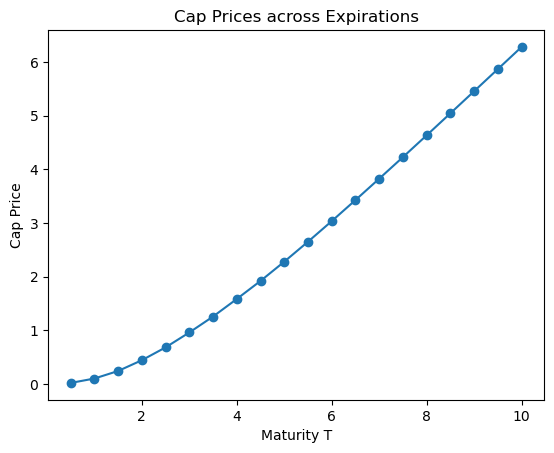

,Maturity,Cap Price
0,0.5,0.023554
1,1.0,0.105505
2,1.5,0.246088
3,2.0,0.446698
4,2.5,0.685471
5,3.0,0.962951
6,3.5,1.259602
7,4.0,1.586384
8,4.5,1.922451
9,5.0,2.280593


In [222]:
import matplotlib.pyplot as plt

N, tau = 100, 0.25
maturities = np.arange(0.5, 10.01, 0.5)
cap_prices = []

for T in maturities:
    K = cap_curves.loc[cap_curves['tenor'] == T, 'swap rates'].iloc[0]
    price = 0
    df_caplets = cap_curves[(cap_curves['tenor'] > 0.25) & (cap_curves['tenor'] <= T)]
    for _, row in df_caplets.iterrows():
        t = row['tenor']
        F = row['forwards']
        sigma = row['flat vols']
        df_t = row['discounts']
        d1 = (np.log(F/K) + 0.5*sigma**2*t) / (sigma*np.sqrt(t))
        d2 = d1 - sigma*np.sqrt(t)
        price += N * tau * df_t * (F*norm.cdf(d1) - K*norm.cdf(d2))
    cap_prices.append(price)

plt.plot(maturities, cap_prices, marker='o')
plt.xlabel('Maturity T')
plt.ylabel('Cap Price')
plt.title('Cap Prices across Expirations')
plt.show()

pd.DataFrame({'Maturity': maturities, 'Cap Price': cap_prices})


### 3.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

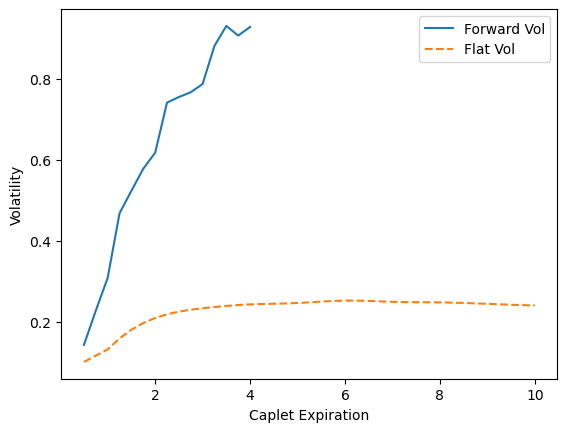

,Tenor,Stripped Caplet Price,Forward Vol,Flat Vol
0,0.50,0.023554,0.143543,0.101500
1,0.75,0.034936,0.228235,0.116946
2,1.00,0.047015,0.308967,0.132391
3,1.25,0.062043,0.468462,0.159421
4,1.50,0.078540,0.523953,0.180856
5,1.75,0.093426,0.578380,0.197446
6,2.00,0.107183,0.617784,0.209941
7,2.25,0.114099,0.741585,0.219090
8,2.50,0.124674,0.755413,0.225643
9,2.75,0.134457,0.767136,0.230349


In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

N, tau = 100, 0.25
tenors = np.arange(0.5, 10+tau, tau)
cap_prices = {}
for T in tenors:
    K = cap_curves.loc[cap_curves['tenor']==T, 'swap rates'].iloc[0]
    price = 0
    rows = cap_curves[(cap_curves['tenor']>0.25) & (cap_curves['tenor']<=T)]
    for _, r in rows.iterrows():
        F, vol, df_t = r['forwards'], r['flat vols'], r['discounts']
        d1 = (np.log(F/K)+0.5*vol**2*r['tenor'])/(vol*np.sqrt(r['tenor']))
        d2 = d1 - vol*np.sqrt(r['tenor'])
        price += N*tau*df_t*(F*norm.cdf(d1)-K*norm.cdf(d2))
    cap_prices[T] = price

stripped_prices, fwd_vols, flat_vols = [], [], []
for T in tenors:
    prev = cap_prices[T-tau] if (T-tau) in cap_prices else 0
    strip = cap_prices[T] - prev
    stripped_prices.append(strip)
    r = cap_curves.loc[cap_curves['tenor']==T].iloc[0]
    F, K, df_t, flat = r['forwards'], r['swap rates'], r['discounts'], r['flat vols']
    flat_vols.append(flat)
    def f(sigma):
        d1 = (np.log(F/K)+0.5*sigma**2*tau)/(sigma*np.sqrt(tau))
        d2 = d1 - sigma*np.sqrt(tau)
        return N*tau*df_t*(F*norm.cdf(d1)-K*norm.cdf(d2)) - strip
    try:
        sigma_fwd = brentq(f, 1e-6, 1)
    except ValueError:
        sigma_fwd = np.nan
    fwd_vols.append(sigma_fwd)

plt.plot(tenors, fwd_vols, label='Forward Vol')
plt.plot(tenors, flat_vols, '--', label='Flat Vol')
plt.xlabel('Caplet Expiration')
plt.ylabel('Volatility')
plt.legend()
plt.show()

pd.DataFrame({'Tenor': tenors,
              'Stripped Caplet Price': stripped_prices,
              'Forward Vol': fwd_vols,
              'Flat Vol': flat_vols})


***